# Lattice light sheet raw data deskew / rotate  in Python -- step by step.

Volker.Hilsenstein@monash.edu

### Aim:

This Jupyter notebook attempts to exlpain the steps involved in deskewing a lattice light sheet raw image volume 
and rotating it back to coverslip coordinates.

### Credits:

* David Potter (Monash) and Keith Schulze for helpful discussions and the sample dataset.
* Talley Lambert for helpful discussions.
* Martin Weigert for assistance and bugfixes to gputools.
* The general workflow outlined in this notebook is modelled on the original Janelia Matlab code
* Felix Kraus from the Ryan Lab at Monash University for the sample image

### Further Resources

* [gputools](https://github.com/maweigert/gputools)
* [Keith Schulzes Scala code](https://monash-merc.github.io/llsm/)
* Harvard (Talley Lambert) have some useful information and visualization here (https://cbmf.hms.harvard.edu/lattice-faqs/)


### Reference


Chen, B.-C., Legant, W. R., Wang, K., Shao, L., Milkie, D. E., Davidson, M. W., et al. (2014). Lattice light-sheet microscopy: imaging molecules to embryos at high spatiotemporal resolution. *Science* (New York, N.Y.), 346(6208), 1257998–1257998. [http://doi.org/10.1126/science.1257998](http://doi.org/10.1126/science.1257998)

# Acquisition with a lattice light sheet microscope

A lattice light sheet microscope based on the Janelia design (see the reference above) has a light sheet that is incident at an oblique angle to the sample coverslip.

Due to the oblique light sheet angle

* the x,y coordinate directiond of individual slices are not perpendicular to the stage z axis, and 
* the acquired image stack appears skewed (sheared is the better term). 

I found it helpful to use a deck of cards as a tactile model for the captured image stack.
During acquisition, the deck of cards is oriented like this (the sample projection is representd by a circle drawn with pencil):

![CARDS1](./notebook_illustrations/cards1.jpg)

However the representation as a `.tif` stack is like this: 
![CARDS2](./notebook_illustrations/cards2.jpg)

We can shift each card such that the sample is no longer distorted:
![CARDS3](./notebook_illustrations/cards3.jpg)
Such a shift can be represented as an affine tranform (specifically: a shearing transform).


## Important parameters
The voxel spacing in x,y is determined by the pixel pitch of the camera and the magnification of the detection object. 
The voxel spacing in z is determined by the stage step size in z direction (coverslip z) and the angle of the light sheet.

Typically (apart from the stage z step size) these values are fixed for a given lattice light sheet microscope.
For our particular microscope the values are:

* light sheet angle: 31.8 degrees
* x,y voxel spacing = 0.1040 $\mu$m

If the stage z step size is $z_{stage}$, the z-voxel spacing is given as
* $z_{voxel} = \sin(31.8) * z_{stage}$




# Workflow outline:

The workflow for deskewing and rotating the raw volume back coverslip coordinates are as follows:

1. Deskew the volume using a shearing transform. 
2. Make the pixel spacing isotropic by scaling and resampling along the Z axis.
3. Rotate the volume such that the z axis of the volume is aligned with the coverlip.

Steps 2 and 3 are optional but may help for downstream visualization and processing.

Each of these steps can be expressed as an [affine transform](https://en.wikipedia.org/wiki/Affine_transformation), that maps a location in the source volume to and location in the output volume. Such an affine transformation can can be represented by a matrix multiplication of the source coordinate (augmented with a 1) by an augmented 4x4 matrix.

In the following we will demonstrate each step individually using three successive affine transforms.
This is for educational purposes only. Because affine transformations are linear, one can combine all three steps into a single affine transformation. The combined transform can be calculated by a simple matrix multiplication of the individual matrices.



# Implementation

* We use `tifffile` to read the source volume (you could also use `skimage.io` or `imread` as a numpy array.
* Affine transforms on volumes are implemented in `scipy.ndimage`, which uses the **CPU** to process them.
* Affine transforms can be computed much faster on a graphics card (**GPU**). One implementation of such a GPU accelerated affine transform is in Martin Weigert's `gputools` package (https://github.com/maweigert/gputools. You need a version of gputools `>= 0.2.8` and you need to install `pyopencl`, which can be a bit tricky. I wrote a wrapper around `gputools`' `affine` function. The wrapper has the same interface as `scipy.ndimage.affine_transform` and handles padding and cropping of the array (something that is provided in `ndimage` by the `output_shape` parameter. If you have `gputools` simply uncomment the `import` statement below.
* We import some helper funtions to display projections in the notebook and to calculate the output size of arrays after an affine transformation.


In [1]:
from transform_helpers import *
from transforms import *
import numpy as np
import tifffile
## Depending on whether you want to use ndimage or gputools, uncomment one of the following
## two lines
#from scipy.ndimage import affine_transform
from gputools_wrapper import affine_transform_gputools as affine_transform
from numpy.linalg import inv
import matplotlib.pyplot as plt
%matplotlib inline



# Parameters

Here we define the parameters as variables. In pratice you will want to extract most of these from the metadata/settings file.

In [2]:
xypixelsize = 0.1040
angle = 31.8
dz_stage = 0.299401
dz = np.sin(angle*np.pi/180.0)*dz_stage
dx = xypixelsize

deskewfactor = np.cos(angle*np.pi/180.0)*dz_stage/dx
dzdx_aspect = dz/dx

print("Parameter summary:")
print("==================")
print("dx, dy:", dx)
print("dz:", dz)
print("deskewfactor:", deskewfactor)
print("voxel aspect ratio z-voxel/xy-voxel:", dzdx_aspect)

Parameter summary:
dx, dy: 0.104
dz: 0.15777109212750076
deskewfactor: 2.4467184824323085
voxel aspect ratio z-voxel/xy-voxel: 1.5170297319951997


# Reading the source volume

In [3]:
# Suppress annoying warnings due to malformed tiffs from Labview
import logging
logging.getLogger("tifffile").setLevel(logging.ERROR)

# Note: you can download the tiff file here https://www.dropbox.com/s/fbqu59o0jo4ijrd/drp1_dendra2_test_1_CamA_ch0_stack0000_488nm_0000000msec_0018218290msecAbs.tif?dl=0

vol = tifffile.imread("/projects/mmi-llsm/Experiment_data_by_lab/Ryan_Lab/Felix_Kraus/20181219_Felix_Dendra2_Drp1_test/Stacks/Stack_1_drp1_dendra2_test_1/drp1_dendra2_test_1_CamA_ch0_stack0000_488nm_0000000msec_0018218290msecAbs.tif")

In [4]:
vol.shape

(76, 512, 256)

### axis order
note that the numpy array is in axis order (z,y,x)

### plot maximum intensity projections along each axis
to inspect the source volume

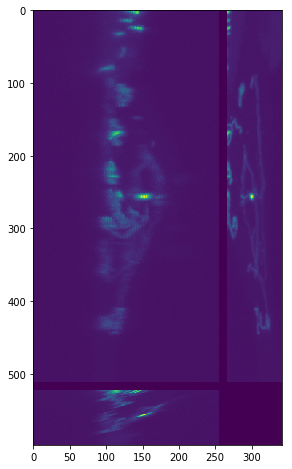

In [5]:
plt.rcParams['figure.figsize'] = (16,8)
plot_all([get_projection_montage(vol)])

# Step 1: Shearing transform

Referring to the deck of card model in the introcution, the amount to shift each slice (card) is given in `deskewfactor`. The required shearing matrix looks like this:

In [6]:
# deskew 
skew = np.eye(4)
skew[2,0] = deskewfactor
skew

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [2.44671848, 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

Note that this transformation will change the output shape of the array. We determine the output shape using a helper function that transforms all the corner points of the input volume and determines their maximum extent after the transformation:

In [7]:
output_shape = get_output_dimensions(skew, vol)
output_shape

array([ 76, 512, 440])

### Apply the transform. 
Note that `scipy.ndimage.affine_transform` and `gputools.affine` (for `gputools >= 0.2.8`) expect the inverse of the transform that we want to do. We choose linear interpolation (order = 0) as this is supported by both libraries.  

In [8]:
deskewed = affine_transform(vol, np.linalg.inv(skew), output_shape=output_shape,order=1)

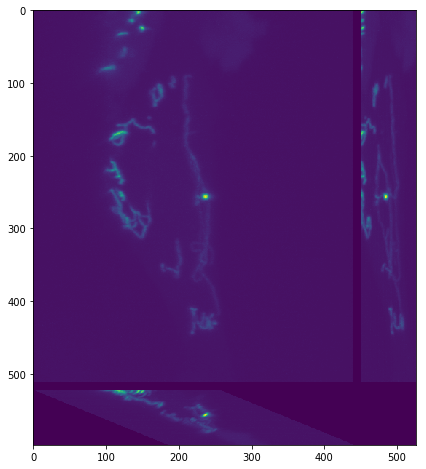

In [9]:
plot_all([get_projection_montage(deskewed)])

The deskewed data is already much easier to work with. You could stop here.
However, the pixel spacing is not isotropic. This can be easily confirmed by measuring the angle. We can see it does not match the 31.8 degrees of the light sheet angle. (TODO: update illustration for new data set)

![ANGLE AFTER DESKEW](./notebook_illustrations/angle_pre_scaling.JPG")

In [10]:
# Save intermediate result for deconvolution notebook
tifffile.imsave("deskewed.tif", deskewed)

# Step 2: Scale Z to create isotropic pixels

This is very simple. We simply scale each Z value by the dz/dx aspect ratio.
The affine transform implementation will deal with the upsampling for us. 

In [11]:
scale = np.eye(4)
scale[0,0] = dzdx_aspect
scale

array([[1.51702973, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [12]:
# Calculate the output shape
output_shape = get_output_dimensions(scale, deskewed)
output_shape

array([116, 512, 440])

In [13]:
scaled_vol = affine_transform(deskewed, np.linalg.inv(scale), output_shape=output_shape, order=1)

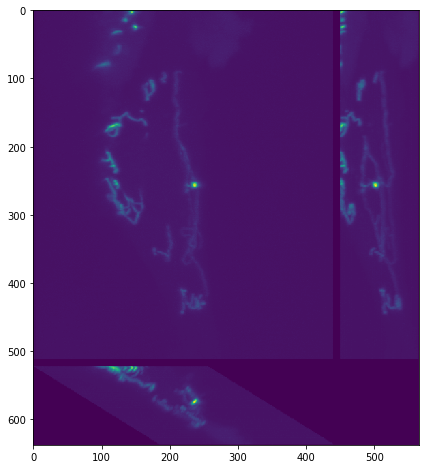

In [14]:
plot_all([get_projection_montage(scaled_vol)])

We can confirm that the angle in the image volume now corresponds to the light sheet angle. We now have istotropic voxels.
TODO: update illustration with current data set

![](./notebook_illustrations/angle_post_scaling.JPG)

# Step 3. Rotate

To align the volume to the coverslip coordinate system we now simply rotate to the left by the lightsheet angle.
A suitable rotation matrix looks like this:

In [15]:
rot = rot_around_y(-angle)
rot

array([[ 0.84989269,  0.        , -0.5269558 ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.5269558 ,  0.        ,  0.84989269,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

However, we can't use this straight away as rotation would be around the origin. We want to rotate around the centre of the volume and therefore shift the centre of the volume to the origin using a translation matrix

In [16]:
shift = shift_centre(scaled_vol.shape)
shift

array([[   1.,    0.,    0.,  -58.],
       [   0.,    1.,    0., -256.],
       [   0.,    0.,    1., -220.],
       [   0.,    0.,    0.,    1.]])

After this, the volume will be larger. The size of the output volume will be:

In [17]:
output_shape = get_output_dimensions(rot @ shift, scaled_vol)
output_shape

array([332, 512, 436])

Note that the `@` sign performs matrix multiplication.

We also have to shift the volume back. We do this by applying a translation that moves the origin to the centre of the output volume shape.

In [18]:
unshift = unshift_centre(output_shape)
unshift

array([[  1.,   0.,   0., 166.],
       [  0.,   1.,   0., 256.],
       [  0.,   0.,   1., 218.],
       [  0.,   0.,   0.,   1.]])

Now we apply the combined transform:

In [19]:
rotated = affine_transform(scaled_vol, np.linalg.inv(unshift @ rot @ shift), output_shape=output_shape, order=1)

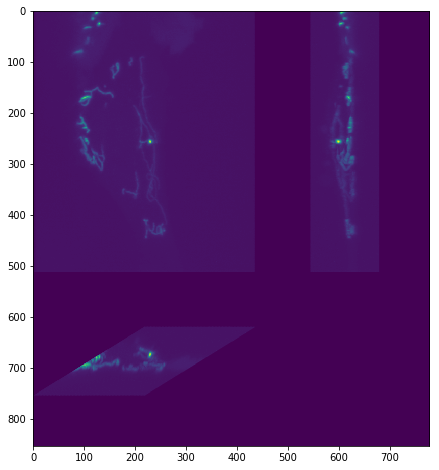

In [20]:
plot_all([get_projection_montage(rotated)])

Now the volume is in coverslip coordinates. Doing everything step by step introduces fill pixels at intermediate steps so this would now need to be cropped. Instead we show how to perform the operation with a single transform:

# All in one ...


We can simply combine multiple affine transformation into a single affine transformation.
This is easiest to express using matrix multiplications. 
In the following we already shift the source volume to the centre, as the translation only affects the rotation but not the shear and the scaling.

In [21]:
shift_original = shift_centre(vol.shape)
shift_original

array([[   1.,    0.,    0.,  -38.],
       [   0.,    1.,    0., -256.],
       [   0.,    0.,    1., -128.],
       [   0.,    0.,    0.,    1.]])

In [22]:
combined = rot @ scale @ skew @ shift_original
combined

array([[-2.06451362e-17,  0.00000000e+00, -5.26955795e-01,
         6.74503418e+01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        -2.56000000e+02],
       [ 2.87885577e+00,  0.00000000e+00,  8.49892693e-01,
        -2.18182784e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [23]:
# determine final output size and required unshift
output_shape = get_output_dimensions(combined, vol)
unshift_final = unshift_centre(output_shape)
output_shape, unshift_final

(array([136, 512, 434]), array([[  1.,   0.,   0.,  68.],
        [  0.,   1.,   0., 256.],
        [  0.,   0.,   1., 217.],
        [  0.,   0.,   0.,   1.]]))

In [24]:
# All in one
all_in_one = unshift_final @ rot @ scale @ skew @ shift_original

# Perform all in one go and show final result

In [25]:
# Apply to source volume:
processed_volume = affine_transform(vol, np.linalg.inv(all_in_one), output_shape=output_shape)

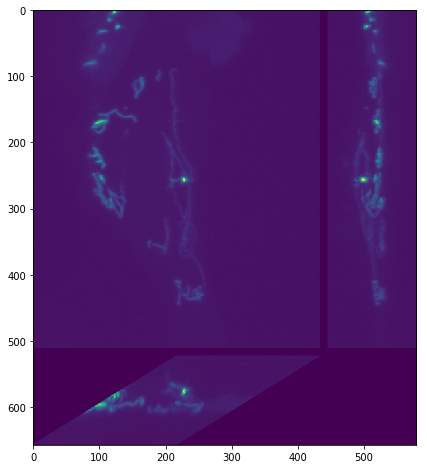

In [26]:
plot_all([get_projection_montage(processed_volume)])